In [319]:
import numpy as np
import pandas as pd
import matplotlib as plt
import pylab as pl
%pylab inline
import seaborn as sns

import statsmodels.formula.api as smf

from mpl_toolkits.mplot3d import Axes3D  # for 3D plot

from sklearn.mixture import GaussianMixture

import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import linalg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier

colors = ['y', 'm', 'c', 'r', 'g', 'b', 'k', 'DeepPink',\
          'DodgerBlue', 'Aquamarine', 'MediumSpringGreen',\
         'MidnightBlue', 'Gold', 'DarkSlateGray', 'LimeGreen', \
         'LightSeaGreen', 'Salmon', 'Indigo', 'DarkMagenta', \
         'Thistle', 'DeepSkyBlue', 'CadetBlue', \
         'BlueViolet', 'Chocolate', 'SaddleBrown', 'Maroon', \
         'Peru', 'DarkOrange', 'Teal', 'DarkKhaki']


Populating the interactive namespace from numpy and matplotlib


/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [79]:
schmelts = ['schmelt05-16.csv', 'schmelt09-16.csv', 'schmelt11-15.csv', 
            'schmelt13-16.csv', 'schmelt96-16.csv']

In [80]:
df = pd.read_csv('./schma_data/{}'.format(schmelts[0]))

In [81]:
df.LCGSCHCAT.value_counts(dropna=False)

ELEMENTARY              792
HIGH SCHOOL             549
JUNIOR HIGH-INTERMED    353
NaN                     112
K-12 ALL GRADES          41
SECONDARY SCHOOL         38
EARLY CHILDHOOD          37
COLLABORATIVE OR MUL     24
K-8                      24
DISTRICT PRE-K CENTE     13
UNGRADED                 12
CENTRAL-HQ-CITYWIDE       1
Name: LCGSCHCAT, dtype: int64

In [226]:
X = df.iloc[:, 1:-16]

In [343]:
list(df.columns)[-12:]

['RenewlSchl',
 'LCGSCHCAT',
 'LCGSCHTYP',
 'HSSCHSAMP2',
 'HSOPCTDRPTOT_cluster',
 'ENRNUMAFM_cluster',
 'ENRNUMHIS_cluster',
 'ENRNUMWHT_cluster',
 'ENRNUMSPD_cluster',
 'ENRPCTAFM_cluster',
 'ENRPCTHIS_cluster',
 'ENRPCTWHT_cluster']

In [346]:
y_cols = list(df.iloc[:, -8:].columns)
y_cols.append('RenewlSchl')

*** Filter out only elementary schools ***

In [254]:
elem = df[df.LCGSCHCAT == 'ELEMENTARY']

In [267]:
elem = elem.dropna(axis=0, how='all',subset=y_cols.columns)

In [268]:
elem.dropna(axis=0, how='all',subset=X.columns, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [269]:
elem.dropna(axis=1, how='all', inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [271]:
drop_list = []
for col in elem.columns:
    if elem[col].isnull().sum() >= 100:
        drop_list.append(col)

In [272]:
len(drop_list)

99

In [273]:
elem.drop(drop_list, axis=1, inplace=True)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [274]:
len(elem.columns)

393

In [277]:
(elem.isnull().sum(axis=1).sort_values(ascending=False)!=0).sum()

146

In [278]:
drop_row = []
for i in elem.index:
    if elem.isnull().sum(axis=1).loc[i] >= 90:
        drop_row.append(i)

In [279]:
len(drop_row)

4

In [280]:
len(elem.isnull().sum(axis=1))

631

In [281]:
elem.drop(drop_row, axis=0, inplace=True)

In [282]:
elem.isnull().sum().sort_values(ascending=False).head(20)

CLSAVGPRK mean05_16     95
CLSNUMPRK range05_16    95
ATTPCTPRK range05_16    95
CLSNUMPRK mean05_16     95
ATTPCTPRK mean05_16     95
CLSAVGPRK range05_16    95
ENRNUMSPD_cluster       31
CLSAVGOHS trend05_16    24
CLSAVGOHS std05_16      24
CLSNUMOHS std05_16      24
CLSNUMOHS trend05_16    24
CLSNUMOHS range05_16    17
CLSNUMOHS mean05_16     17
CLSAVGOHS range05_16    17
CLSAVGOHS mean05_16     17
CLSAVGG03 std05_16       5
ATTPCTG05 range05_16     5
ATTPCTG01 mean05_16      5
ATTPCTG05 std05_16       5
ATTPCTKID std05_16       5
dtype: int64

ATTPCTPRK - pre k -- fill w 0   - done
CLSAVGSPD - special ed -- fill w 0  -done
CLSNUMOHS - AVERAGE NUM OF STU PER CLASS: OTHER HIGH SCHOOLS (ENRNUM/CLSNUM) - drop for elem  - done

No values for the features below bc they don't have a 5th grade -- so no growth, or 5th grade ela proficiency
-- fill with value from 3rd gade proficiency and make growth == 0  
E_growth trend05_16   - filled w 0 - done           
E_growth std05_16                  - filled w 0 - done
ela5_decile trend05_16          - filled w. val for ela3 - done
ela5_decile std05_16   - filled w  vale for ela3 - done

fill with grade 3 value  
STCELAPCTL34G05 std05_16       
STCMTHPCTL34G05 std05_16         
STCELAPCTL34G05 trend05_16     
STCMTHPCTL34G05 trend05_16 


In [283]:
sub = 'PRK'
prk_cols = [s for s in elem.columns if sub in s]
print (prk_cols)
df[prk_cols] = df[prk_cols].fillna(value=0)

['ENRNUMPRK trend05_16', 'ATTPCTPRK mean05_16', 'CLSAVGPRK mean05_16', 'CLSNUMPRK mean05_16', 'ENRNUMPRK mean05_16', 'ENRNUMPRK std05_16', 'ATTPCTPRK range05_16', 'CLSAVGPRK range05_16', 'CLSNUMPRK range05_16', 'ENRNUMPRK range05_16']


In [284]:
sub = 'SPD'
SPD_cols = [s for s in elem.columns if sub in s]
print (SPD_cols)
df[SPD_cols] = df[SPD_cols].fillna(value=0)

['CLSAVGSPD trend05_16', 'CLSNUMSPD trend05_16', 'ENRNUMSPD trend05_16', 'CLSAVGSPD mean05_16', 'CLSNUMSPD mean05_16', 'ENRNUMSPD mean05_16', 'CLSAVGSPD std05_16', 'CLSNUMSPD std05_16', 'ENRNUMSPD std05_16', 'CLSAVGSPD range05_16', 'CLSNUMSPD range05_16', 'ENRNUMSPD range05_16', 'ENRNUMSPD_cluster']


In [285]:
sub = 'OHS'
OHS_cols = [s for s in elem.columns if sub in s]
print (OHS_cols)
elem.drop(OHS_cols, axis=1, inplace=True)

['CLSAVGOHS trend05_16', 'CLSNUMOHS trend05_16', 'ENRNUMOHS trend05_16', 'CLSAVGOHS mean05_16', 'CLSNUMOHS mean05_16', 'ENRNUMOHS mean05_16', 'CLSAVGOHS std05_16', 'CLSNUMOHS std05_16', 'ENRNUMOHS std05_16', 'CLSAVGOHS range05_16', 'CLSNUMOHS range05_16', 'ENRNUMOHS range05_16']


In [286]:
elem[['E_growth trend05_16','E_growth std05_16']] = elem[['E_growth trend05_16','E_growth std05_16']].fillna(0)

In [287]:
elem['ela5_decile trend05_16'] = elem['ela5_decile trend05_16'].fillna(elem['ela3_decile trend05_16'])
elem['ela5_decile std05_16'] = elem['ela5_decile std05_16'].fillna(elem['ela3_decile std05_16'])

In [288]:
for col in ['STCELAPCTL34G{} std05_16', 'STCMTHPCTL34G{} std05_16', 
            'STCELAPCTL34G{} trend05_16', 'STCMTHPCTL34G{} trend05_16']:
    elem[col.format('04')] = elem[col.format('04')].fillna(elem[col.format('03')])
    elem[col.format('05')] = elem[col.format('05')].fillna(elem[col.format('04')])

In [289]:
elem.isnull().sum().sort_values(ascending=False).head(20)

CLSNUMPRK mean05_16     95
ATTPCTPRK range05_16    95
CLSNUMPRK range05_16    95
ATTPCTPRK mean05_16     95
CLSAVGPRK mean05_16     95
CLSAVGPRK range05_16    95
ENRNUMSPD_cluster       31
CLSAVGG04 range05_16     5
CLSNUMKID std05_16       5
CLSNUMKID mean05_16      5
CLSNUMG03 std05_16       5
CLSNUMG04 std05_16       5
CLSAVGKID std05_16       5
CLSAVGG04 std05_16       5
ATTPCTKID std05_16       5
ATTPCTG05 std05_16       5
CLSNUMG04 mean05_16      5
CLSNUMG04 range05_16     5
CLSAVGKID mean05_16      5
CLSAVGG04 mean05_16      5
dtype: int64

All missing bc there isn't  a 4th or 5th grade class, so can fill in w 0

CLSNUMG04 std05_16  
CLSAVGG04 std05_16  
CLSAVGG04 trend05_16
CLSNUMG04 trend05_16
ATTPCTG05 trend05_16
ATTPCTG05 std05_16

enrollment values for dif demographics- can fill w 0
POV = poverty index
ELL = eng lang learners
OTH = other

ENRNUMPOV std05_16     
ENRNUMELL std05_16     
ENRNUMELL trend05_16  
ENRNUMELL mean05_16  
ENRNUMPOV range05_16  
ENRNUMOTH range05_16   
ENRNUMOTH std05_16     
ENRNUMOTH trend05_16 
ENRNUMPOV trend05_16 
ENRNUMELL range05_16
ENRNUMPOV mean05_16       
ENRNUMOTH mean05_16

In [290]:
cols_toz = ['CLSNUMG04 std05_16', 'CLSAVGG04 std05_16', 'CLSAVGG04 trend05_16',
            'CLSNUMG04 trend05_16', 'ATTPCTG05 trend05_16','ATTPCTG05 std05_16',
           'ENRNUMPOV std05_16','ENRNUMELL std05_16','ENRNUMELL trend05_16',
            'ENRNUMELL mean05_16','ENRNUMPOV range05_16','ENRNUMOTH range05_16',
            'ENRNUMOTH std05_16','ENRNUMOTH trend05_16','ENRNUMPOV trend05_16',
            'ENRNUMELL range05_16','ENRNUMPOV mean05_16','ENRNUMOTH mean05_16']

In [291]:
elem[cols_toz] = elem[cols_toz].fillna(0)

# Q: Should all this be feature engineered on the original SCHMA?

DMGPCTELLTOT - % ELL enrolled, impute to 0

growth vals - still na aftet imputing 3 g vals
-- set equal to 0? Or not enough information about the school? ie. not many grades to make a prediction on/to be relevant
ela3_decile std05_16          
ela5_decile std05_16          
ela5_decile trend05_16

In [211]:
elem[elem['ela3_decile std05_16'].isnull()][['STCELAPCTL34G03 mean05_16','STCELAPCTL34G03 std05_16' ,'ela3_decile std05_16']]

,STCELAPCTL34G03 mean05_16,STCELAPCTL34G03 std05_16,ela3_decile std05_16
161,31.800000,NaN,NaN
275,15.400000,NaN,NaN
285,NaN,NaN,NaN
674,35.600000,NaN,NaN
834,53.658540,NaN,NaN
937,NaN,NaN,NaN
940,40.909090,NaN,NaN
943,82.608700,NaN,NaN
1119,21.428570,NaN,NaN
1139,78.852549,22.976079,NaN


Why would a school have a vlaue for the mean, but not the std?

Fill in the rest of the Nans with 0z

In [292]:
elem = elem.fillna(0)

In [296]:
elem.columns

Index(['BNLONG', 'ATTPCTG01 trend05_16', 'ATTPCTG02 trend05_16',
       'ATTPCTG03 trend05_16', 'ATTPCTG04 trend05_16', 'ATTPCTG05 trend05_16',
       'ATTPCTKID trend05_16', 'ATTPCTTOT trend05_16', 'CBO trend05_16',
       'CLSAVGG01 trend05_16',
       ...
       'LCGSCHCAT', 'LCGSCHTYP', 'HSSCHSAMP2', 'ENRNUMAFM_cluster',
       'ENRNUMHIS_cluster', 'ENRNUMWHT_cluster', 'ENRNUMSPD_cluster',
       'ENRPCTAFM_cluster', 'ENRPCTHIS_cluster', 'ENRPCTWHT_cluster'],
      dtype='object', length=381)

In [303]:
elem.iloc[:, 1:-14]

,ATTPCTG01 trend05_16,ATTPCTG02 trend05_16,ATTPCTG03 trend05_16,ATTPCTG04 trend05_16,ATTPCTG05 trend05_16,ATTPCTKID trend05_16,ATTPCTTOT trend05_16,CBO trend05_16,CLSAVGG01 trend05_16,CLSAVGG02 trend05_16,...,STCELAPCTL34G03 range05_16,STCELAPCTL34G04 range05_16,STCELAPCTL34G05 range05_16,STCELAPCTL34TOT range05_16,STCMTHPCTL34G03 range05_16,STCMTHPCTL34G04 range05_16,STCMTHPCTL34G05 range05_16,STCMTHPCTL34TOT range05_16,ela3_decile range05_16,ela5_decile range05_16
0,0.220909,0.189091,0.204545,0.250909,0.177273,0.191818,0.242727,0.0,0.200866,0.694805,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
2,0.290909,0.019091,0.089091,0.065455,0.181818,-0.069091,0.052727,0.0,0.672727,0.018182,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
4,0.610000,0.410000,0.164545,0.283636,0.459091,0.234545,0.297273,0.0,-0.209091,0.151515,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
5,0.308182,0.107273,0.088182,-0.088182,0.156364,0.600000,0.140000,0.0,0.496753,0.854545,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
6,0.174545,0.102727,0.097273,0.062727,0.400000,0.069091,0.150000,0.0,0.200957,0.738756,...,12.0,12.0,4.0,12.0,12.0,12.0,4.0,12.0,12.0,4.0
7,0.422727,0.230000,0.424545,0.217273,0.700909,0.303636,0.392727,0.0,0.313131,-1.717172,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
8,0.678182,0.490000,0.349091,0.314545,0.294545,0.645455,0.513636,0.0,0.681818,1.220779,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
9,0.300000,0.228182,0.444545,0.310000,0.281818,0.482727,0.337273,0.0,2.090909,1.668182,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
10,0.567273,0.274545,0.526364,0.233636,0.490000,0.964545,0.486364,0.0,1.284848,1.141414,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
11,0.507273,0.373636,0.217273,0.524545,0.451818,0.568182,0.412727,0.0,1.878788,-0.333333,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0


In [547]:
X = elem.iloc[:, 1:-14]

In [325]:
y_cols.columns[1:]

Index(['ENRNUMAFM_cluster', 'ENRNUMHIS_cluster', 'ENRNUMWHT_cluster',
       'ENRNUMSPD_cluster', 'ENRPCTAFM_cluster', 'ENRPCTHIS_cluster',
       'ENRPCTWHT_cluster'],
      dtype='object')

In [329]:
def tree_fits(X, y):
    #split training and test data (Set before the missing dates, and after the missing dates)
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=999)
    
   
    # learn model
    dt=DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    
    print ('Decision Tree Classifier Results: ')
    # in sample accuracy
    print ('In sample accuracy:',dt.score(X_train,y_train))

    # out of sample accuracy
    print ('Out of sample accuracy:',dt.score(X_test,y_test))

    print ('\n')
    # learn model
    dt=RandomForestClassifier()
    dt.fit(X_train,y_train)

    # in sample accuracy
    print ('Random Forest Classifier Results: ')
    print ('In sample accuracy:',dt.score(X_train,y_train))

    # out of sample accuracy
    print ('Out of sample accuracy:',dt.score(X_test,y_test))
    
    print ('\n')
    
    # learn model
    dt=ExtraTreeClassifier()
    dt.fit(X_train,y_train)

    print ('Extra Tree Classifier Results: ')
    # in sample accuracy
    print ('In sample accuracy:',dt.score(X_train,y_train))

    # out of sample accuracy
    print ('Out of sample accuracy:',dt.score(X_test,y_test))
    print ('\n')
    

In [350]:
for y_col in y_cols[1:]:
    y = elem[y_col]
    print ('Elementary, {} Decision Tree Results (no tuning): '.format(y_col))
    tree_fits(X, y)

Elementary, ENRNUMAFM_cluster Decision Tree Results (no tuning): 
Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.375661375661


Random Forest Classifier Results: 
In sample accuracy: 0.981735159817
Out of sample accuracy: 0.492063492063


Extra Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.402116402116


Elementary, ENRNUMHIS_cluster Decision Tree Results (no tuning): 
Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.497354497354


Random Forest Classifier Results: 
In sample accuracy: 0.990867579909
Out of sample accuracy: 0.481481481481


Extra Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.333333333333


Elementary, ENRNUMWHT_cluster Decision Tree Results (no tuning): 
Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.507936507937


Random Forest Classifier Results: 
In sample accuracy: 0.997716894977
Out of sample ac

*** Enrnum african american cluster ***

In [548]:
y = elem['ENRNUMAFM_cluster']

In [549]:
sub = 'AFM'
nafm_cols = [s for s in X.columns if sub not in s]

In [550]:
X = X[nafm_cols]

In [551]:
y = elem['ENRNUMAFM_cluster']

In [552]:
#X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=999)

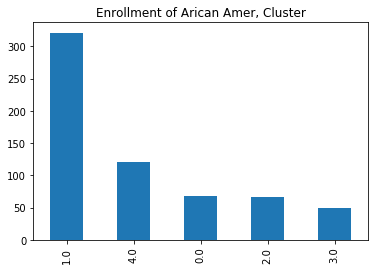

In [553]:
df_train = X.copy()
df_train['EnrAfmClust'] = y.copy()
df_train['EnrAfmClust'].value_counts().plot(kind='bar', title='Enrollment of Arican Amer, Cluster')

In [554]:
#resample to rebalance classes
# Class count
count_class_1, count_class_4, count_class_2, count_class_0, count_class_3 = df_train['EnrAfmClust'].value_counts()

# Divide by class
df_class_1 = df_train[df_train['EnrAfmClust'] == 1.0]
df_class_4 = df_train[df_train['EnrAfmClust'] == 4.0]
df_class_2 = df_train[df_train['EnrAfmClust'] == 2.0]
df_class_0 = df_train[df_train['EnrAfmClust'] == 0.0]
df_class_3 = df_train[df_train['EnrAfmClust'] == 3.0]

Random over-sampling:
0.0    321
4.0    321
3.0    321
2.0    321
1.0    321
Name: EnrAfmClust, dtype: int64


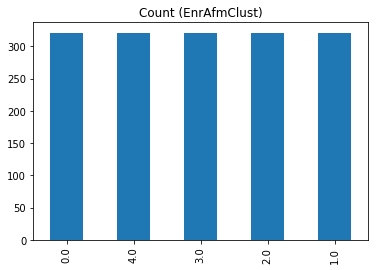

In [555]:
df_class_4_over = df_class_4.sample(count_class_1, replace=True) #take the number of fatal accidents as slight
df_class_2_over = df_class_2.sample(count_class_1, replace=True)
df_class_3_over = df_class_3.sample(count_class_1, replace=True) #take the number of fatal accidents as slight
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_train_over = pd.concat([df_class_1, df_class_2_over, df_class_3_over, df_class_4_over, df_class_0_over], axis=0)

print('Random over-sampling:')
print(df_train_over['EnrAfmClust'].value_counts())

df_train_over['EnrAfmClust'].value_counts().plot(kind='bar', title='Count (EnrAfmClust)');

In [579]:
#y = elem['ENRNUMAFM_cluster']

X_train,X_test,y_train,y_test=train_test_split(df_train_over[X.columns], df_train_over['EnrAfmClust'], test_size=0.3, random_state=999)


In [585]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)

#from sklearn.model_selection import GridSearchCV 
param_grid ={'max_depth':np.arange(1,20,2),
            'max_leaf_nodes':np.arange(2,20,2)} #choose a grid of parameters

OS=[]
for i in range(10):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)
    dt=RandomForestClassifier()#don't specifcy alpha in the intialization
    gr=GridSearchCV(dt,param_grid=param_grid)#pass in predictor, and gridded parameters
    rs=gr.fit(X_train,y_train)#run predictor with each parameter using training data
    print (rs.best_params_) #will output the best parameter, the best alpha
    OS.append((rs.predict(X_test) == y_test).sum() / len(y_test))
print (np.mean(OS))

{'max_depth': 7, 'max_leaf_nodes': 18}
{'max_depth': 11, 'max_leaf_nodes': 18}
{'max_depth': 9, 'max_leaf_nodes': 18}
{'max_depth': 7, 'max_leaf_nodes': 18}
{'max_depth': 19, 'max_leaf_nodes': 18}
{'max_depth': 15, 'max_leaf_nodes': 18}
{'max_depth': 9, 'max_leaf_nodes': 18}
{'max_depth': 15, 'max_leaf_nodes': 18}
{'max_depth': 15, 'max_leaf_nodes': 18}
{'max_depth': 13, 'max_leaf_nodes': 18}
0.660373443983


In [586]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)

#from sklearn.model_selection import GridSearchCV 
param_grid ={'n_estimators':np.arange(1,52,3),
            'min_samples_leaf':np.arange(1,50,5)} #choose a grid of parameters

OS=[]
for i in range(10):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = i)
    dt=RandomForestClassifier(max_depth=10, max_leaf_nodes=18)#don't specifcy alpha in the intialization
    gr=GridSearchCV(dt,param_grid=param_grid)#pass in predictor, and gridded parameters
    rs=gr.fit(X_train,y_train)#run predictor with each parameter using training data
    print (rs.best_params_) #will output the best parameter, the best alpha
    OS.append((rs.predict(X_test) == y_test).sum() / len(y_test))
print (np.mean(OS))

{'min_samples_leaf': 1, 'n_estimators': 43}
{'min_samples_leaf': 6, 'n_estimators': 49}
{'min_samples_leaf': 6, 'n_estimators': 37}
{'min_samples_leaf': 6, 'n_estimators': 49}
{'min_samples_leaf': 1, 'n_estimators': 34}
{'min_samples_leaf': 6, 'n_estimators': 49}
{'min_samples_leaf': 6, 'n_estimators': 46}
{'min_samples_leaf': 11, 'n_estimators': 37}
{'min_samples_leaf': 6, 'n_estimators': 31}
{'min_samples_leaf': 11, 'n_estimators': 46}
0.719917012448


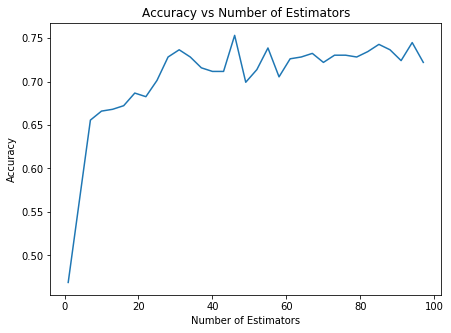

In [588]:
n_est = np.arange(1,100,3)
OS_ = []
for i in n_est:
    rf = RandomForestClassifier(n_estimators=i, n_jobs=-1,min_samples_leaf=6, max_depth=10, max_leaf_nodes=18)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rf.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(n_est,OS_)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
#plt.xlim(2,500)
plt.show()

In [589]:
rf = RandomForestClassifier(n_estimators=60, n_jobs=-1,min_samples_leaf=6, max_depth=10, max_leaf_nodes=18)
rf.fit(X_train, y_train)
pred=rf.predict(X_test)

print ('Random Forest Classifier Results: ')
print ('In sample accuracy:',rf.score(X_train,y_train))

# out of sample accuracy
print ('Out of sample accuracy:',rf.score(X_test,y_test))


Random Forest Classifier Results: 
In sample accuracy: 0.831700801425
Out of sample accuracy: 0.730290456432


In [590]:
fet_imp = pd.DataFrame(list(zip(list(X.columns), rf.feature_importances_)), columns=['Variable', 'Importance'])

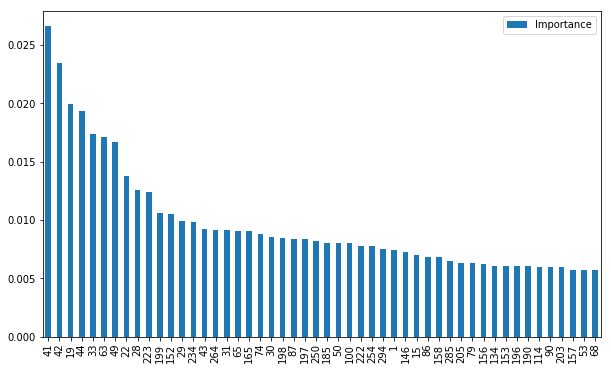

In [591]:
fet_imp.sort_values(by=['Importance'], ascending=False).head(50).plot(kind='bar', figsize=(10,6))

([<matplotlib.axis.YTick at 0x1c251297f0>,
 <a list of 14 Text yticklabel objects>)

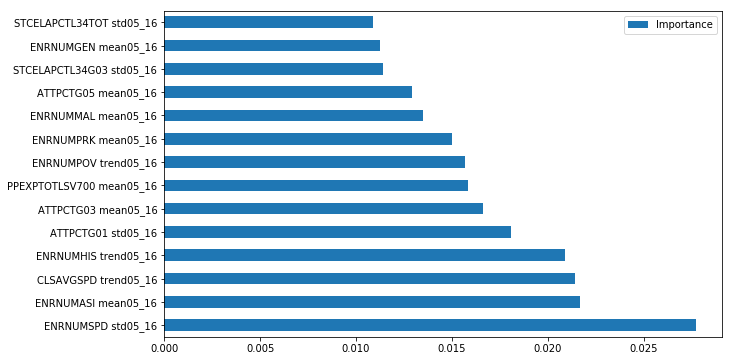

In [771]:
fet_imp.sort_values(by=['Importance'], ascending=False).head(14).plot(kind='barh', figsize=(10,6))

pl.yticks(np.arange(len(labels)), labels)


Variable	Importance
41	ENRNUMGEN trend05_16 ---> the trend in gen ed student enrollment numbers
42	ENRNUMHIS trend05_16 ---> trend in enrollement of hispanic students from 05-16
19	CLSNUMGEN trend05_16 ---> trend in the number of gen ed classes

In [594]:
fet_imp.sort_values(by=['Importance'], ascending=False).iloc[:14, :]

,Variable,Importance
41,ENRNUMGEN trend05_16,0.026624
42,ENRNUMHIS trend05_16,0.023497
19,CLSNUMGEN trend05_16,0.019952
44,ENRNUMMAL trend05_16,0.019365
33,ENRNUMG05 trend05_16,0.017349
63,PPEXPTOTLSV400 trend05_16,0.017130
49,ENRNUMTOT trend05_16,0.016676
22,CLSNUMTOT trend05_16,0.013768
28,ENRNUMFEM trend05_16,0.012545
223,ENRNUMHIS std05_16,0.012371


In [759]:
labels = fet_imp.sort_values(by=['Importance'], ascending=False).iloc[:14, :].Variable

In [595]:
clust_feats = list(fet_imp.sort_values(by=['Importance'], ascending=False).iloc[:14, :]['Variable'])

ENRNUMG05 Num 8 ENROLLMENT: NUMBER GRADE 5  
CLSNUMGEN Num 8 NUMBER OF CLASSES: ALL GENERAL/REGULAR EDUCATION  
ATTPCTKID Num 8 8.1 SCH ATTENDANCE RATE: KINDERGARTEN    
ENRNUMGEN Num 8 ENROLLMENT: NUMBER ALL REGULAR EDUCATION  
ENRNUMTOT Num 8 ENROLLMENT: TOTAL  
CLSAVGG03 Num 8 AVERAGE NUM OF STU PER CLASS: GRADE 3  
STCELAPCTL34G05 Num 8 ELA STATE TEST, NYC: PERCENT AT LEVEL THREE OR FOUR, GRADE 5
ENRNUMG07 Enrollment number in grade 7  
STCELAPCTL34G03 Num 8 ELA STATE TEST, NYC: PERCENT AT LEVEL THREE OR FOUR, GRADE 3  
CLSNUMG03 Num 8 NUMBER OF CLASSES: GRADE 3  
STCMTHPCTL34TOT Num 8 MATH STATE TEST, NYC: PERCENT AT LEVEL THREE OR FOUR, ALL GRADES  
ENRNUMPOV Num 8 ENROLLMENT: NUMBER WITH POVERTY-INDICATOR  

In [596]:
y_test.value_counts()

3.0    102
2.0    101
0.0     97
1.0     94
4.0     88
Name: EnrAfmClust, dtype: int64

In [598]:
X_train_nu = X_train[clust_feats]
X_test_nu = X_test[clust_feats]

In [599]:
# learn model
dt=DecisionTreeClassifier()
dt.fit(X_train_nu,y_train)

print ('Decision Tree Classifier Results: ')
# in sample accuracy
print ('In sample accuracy:',dt.score(X_train_nu,y_train))

# out of sample accuracy
print ('Out of sample accuracy:',dt.score(X_test_nu,y_test))

Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.856846473029


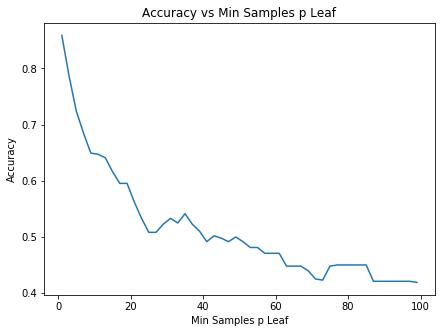

In [600]:
#min_samples_leaf = 
    
min_sam = np.arange(1,100,2)
OS_ = []
for i in min_sam:
    dt = DecisionTreeClassifier(min_samples_leaf=i, random_state=999)
    dt.fit(X_train_nu, y_train)
    pred=dt.predict(X_test_nu)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((dt.predict(X_test_nu) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(min_sam,OS_)
plt.xlabel("Min Samples p Leaf")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Min Samples p Leaf")
#plt.xlim(2,500)
plt.show()

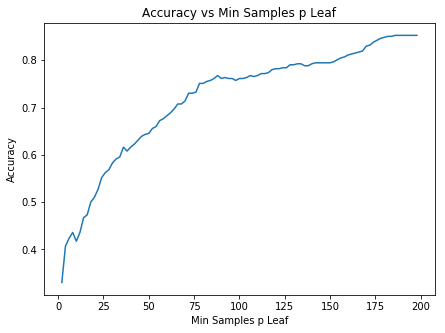

In [604]:
#min_samples_leaf = 
    
max_no = np.arange(2,200,2)
OS_ = []
for i in max_no:
    dt = DecisionTreeClassifier(max_leaf_nodes=i, random_state=999)
    dt.fit(X_train_nu, y_train)
    pred=dt.predict(X_test_nu)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((dt.predict(X_test_nu) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(max_no,OS_)
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Min Samples p Leaf")
#plt.xlim(2,500)
plt.show()

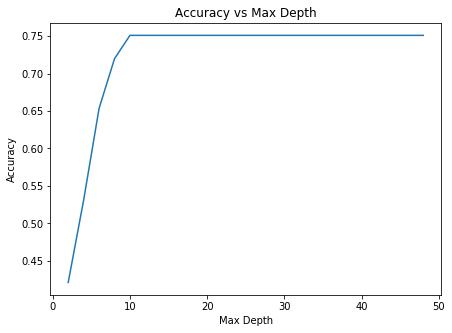

In [612]:
#min_samples_leaf = 
    
max_no = np.arange(2,50,2)
OS_ = []
for i in max_no:
    dt = DecisionTreeClassifier(max_leaf_nodes=80,max_depth=i ,random_state=999)
    dt.fit(X_train_nu, y_train)
    pred=dt.predict(X_test_nu)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((dt.predict(X_test_nu) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(max_no,OS_)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth")
#plt.xlim(2,500)
plt.show()

In [642]:
# learn model
dt=DecisionTreeClassifier(max_leaf_nodes=10,max_depth=5, random_state=999)
dt.fit(X_train_nu,y_train)

print ('Decision Tree Classifier Results: ')
# in sample accuracy
print ('In sample accuracy:',dt.score(X_train_nu,y_train))

# out of sample accuracy
print ('Out of sample accuracy:',dt.score(X_test_nu,y_test))

Decision Tree Classifier Results: 
In sample accuracy: 0.46571682992
Out of sample accuracy: 0.417012448133


In [633]:
type(y_test.iloc[0])

numpy.float64

In [627]:
from sklearn.metrics import confusion_matrix

In [634]:
count_cls_3, count_cls_2, count_cls_0, count_cls_1 , count_cls_4=y_test.value_counts()
y_pred = dt.predict(X_test_nu)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[3.0, 2.0, 0.0, 1.0, 4.0])
print('Confusion matrix:\n', conf_mat)

conf_mat_pct = (np.array(conf_mat.T / np.array([count_cls_3, count_cls_2, count_cls_0, count_cls_1 , count_cls_4])).T)*100.00

Confusion matrix:
 [[69 13  7  3 10]
 [ 3 70 13 12  3]
 [10 19 62  1  5]
 [ 5 27 19 33 10]
 [ 0 17 10 40 21]]


Confusion matrix, (%):
 [[ 67.64705882  12.74509804   6.8627451    2.94117647   9.80392157]
 [  2.97029703  69.30693069  12.87128713  11.88118812   2.97029703]
 [ 10.30927835  19.58762887  63.91752577   1.03092784   5.15463918]
 [  5.31914894  28.72340426  20.21276596  35.10638298  10.63829787]
 [  0.          19.31818182  11.36363636  45.45454545  23.86363636]]


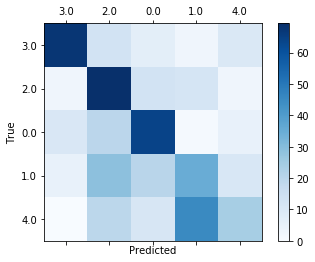

In [636]:
print('Confusion matrix, (%):\n', conf_mat_pct)

labels = [3.0, 2.0, 0.0, 1.0, 4.0]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_pct, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [637]:
y_test.value_counts()

3.0    102
2.0    101
0.0     97
1.0     94
4.0     88
Name: EnrAfmClust, dtype: int64

In [643]:
clsses = [str(cl) for cl in dt.classes_]

In [650]:
thestring=tree.export_graphviz(dt, out_file=None, feature_names=X_train_nu.columns.values,
                              class_names=clsses, filled=True)
print (thestring)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="ENRNUMGEN trend05_16 <= 2.636\ngini = 0.8\nsamples = 1123\nvalue = [224, 227, 220, 219, 233]\nclass = 4.0", fillcolor="#e539c002"] ;
1 [label="ENRNUMTOT trend05_16 <= -10.318\ngini = 0.779\nsamples = 746\nvalue = [132, 175, 192, 63, 184]\nclass = 2.0", fillcolor="#39e5c504"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
3 [label="ENRNUMFEM trend05_16 <= -5.045\ngini = 0.689\nsamples = 270\nvalue = [10, 99, 47, 12, 102]\nclass = 4.0", fillcolor="#e539c004"] ;
1 -> 3 ;
15 [label="gini = 0.697\nsamples = 244\nvalue = [10, 97, 46, 12, 79]\nclass = 1.0", fillcolor="#7be5391c"] ;
3 -> 15 ;
16 [label="gini = 0.21\nsamples = 26\nvalue = [0, 2, 1, 0, 23]\nclass = 4.0", fillcolor="#e539c0df"] ;
3 -> 16 ;
4 [label="ENRNUMG01 trend05_16 <= -1.773\ngini = 0.775\nsamples = 476\nvalue = [122, 76, 145, 51, 82]\nclass = 2.0", fillcolor="#39e5c511"] ;
1 -> 4 ;
11 [label="PPEXPTOTLSV400 trend05_16 <= 21.812\ngini

In [648]:
from sklearn import tree
thestring=tree.export_graphviz(dt,out_file=None, feature_names=X_train_nu.columns.values,\
                               class_names=clsses,  filled=True, rotate=True,  \
                                special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
print (thestring)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
rankdir=LR ;
0 [label="ENRNUMGEN trend05_16 <= 2.636, samples = 1123, value = [224, 227, 220, 219, 233], class = 4.0", fillcolor="#e539c002"] ;
1 [label="ENRNUMTOT trend05_16 <= -10.318, samples = 746, value = [132, 175, 192, 63, 184], class = 2.0", fillcolor="#39e5c504"] ;
0 -> 1 [labeldistance=2.5, labelangle=-45, headlabel="True"] ;
3 [label="ENRNUMFEM trend05_16 <= -5.045, samples = 270, value = [10, 99, 47, 12, 102], class = 4.0", fillcolor="#e539c004"] ;
1 -> 3 ;
15 [label="samples = 244, value = [10, 97, 46, 12, 79], class = 1.0", fillcolor="#7be5391c"] ;
3 -> 15 ;
16 [label="samples = 26, value = [0, 2, 1, 0, 23], class = 4.0", fillcolor="#e539c0df"] ;
3 -> 16 ;
4 [label="ENRNUMG01 trend05_16 <= -1.773, samples = 476, value = [122, 76, 145, 51, 82], class = 2.0", fillcolor="#39e5c511"] ;
1 -> 4 ;
11 [label="PPEXPTOTLSV400 trend05_16 <= 21.812, samples = 162, value = [27, 22, 85, 14, 14], class = 2.0", fillcolor="#

*** Random Forest and Feature Selection for the White Enrollment Cluster ***

In [675]:
X = elem.iloc[:, 1:-14]
y = elem['ENRPCTWHT_cluster']
sub = 'WHT'
nwht_cols = [s for s in X.columns if sub not in s]
X = X[nwht_cols]

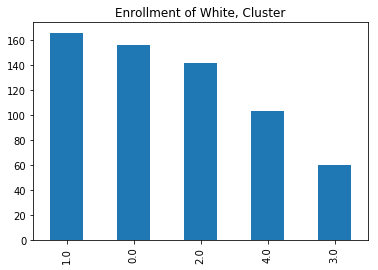

In [676]:
df_train = X.copy()
df_train['EnrWhtClust'] = y.copy()
df_train['EnrWhtClust'].value_counts().plot(kind='bar', title='Enrollment of White, Cluster')

In [677]:
#resample to rebalance classes
# Class count
count_class_1, count_class_0, count_class_2, count_class_4, count_class_3 = df_train['EnrWhtClust'].value_counts()

# Divide by class
df_class_1 = df_train[df_train['EnrWhtClust'] == 1.0]
df_class_4 = df_train[df_train['EnrWhtClust'] == 4.0]
df_class_2 = df_train[df_train['EnrWhtClust'] == 2.0]
df_class_0 = df_train[df_train['EnrWhtClust'] == 0.0]
df_class_3 = df_train[df_train['EnrWhtClust'] == 3.0]

Random over-sampling:
0.0    166
4.0    166
3.0    166
2.0    166
1.0    166
Name: EnrWhtClust, dtype: int64


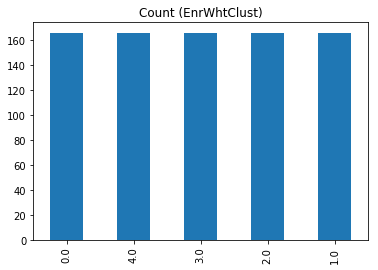

In [678]:
df_class_4_over = df_class_4.sample(count_class_1, replace=True) #take the number of fatal accidents as slight
df_class_2_over = df_class_2.sample(count_class_1, replace=True)
df_class_3_over = df_class_3.sample(count_class_1, replace=True) #take the number of fatal accidents as slight
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_train_over = pd.concat([df_class_1, df_class_2_over, df_class_3_over, df_class_4_over, df_class_0_over], axis=0)

print('Random over-sampling:')
print(df_train_over['EnrWhtClust'].value_counts())

df_train_over['EnrWhtClust'].value_counts().plot(kind='bar', title='Count (EnrWhtClust)');

In [679]:
#y = elem['ENRNUMAFM_cluster']

X_train,X_test,y_train,y_test=train_test_split(df_train_over[X.columns], df_train_over['EnrWhtClust'], test_size=0.3, random_state=999)


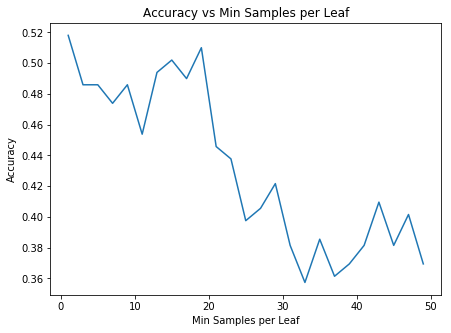

In [680]:
min_samp = np.arange(1,50,2)
OS_ = []
for i in min_samp:
    rf = RandomForestClassifier(n_estimators=10, n_jobs=-1,min_samples_leaf=i, max_depth=10, max_leaf_nodes=18)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rf.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(min_samp,OS_)
plt.xlabel("Min Samples per Leaf")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Min Samples per Leaf")
#plt.xlim(2,500)
plt.show()

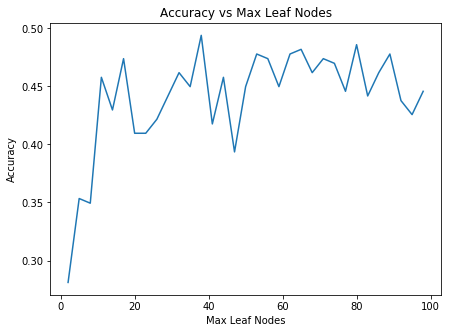

In [681]:
m_lno = np.arange(2,100,3)
OS_ = []
for i in m_lno:
    rf = RandomForestClassifier(n_estimators=10, n_jobs=-1,min_samples_leaf=20, max_depth=10, max_leaf_nodes=i)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rf.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(m_lno,OS_)
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Leaf Nodes")
#plt.xlim(2,500)
plt.show()

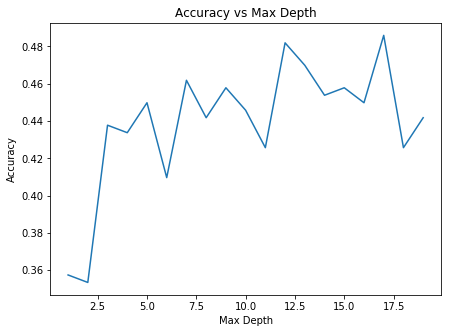

In [682]:
max_d = np.arange(1,20,1)
OS_ = []
for i in max_d:
    rf = RandomForestClassifier(n_estimators=10, n_jobs=-1,min_samples_leaf=20, max_depth=i, max_leaf_nodes=40)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rf.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(max_d,OS_)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth")
#plt.xlim(2,500)
plt.show()

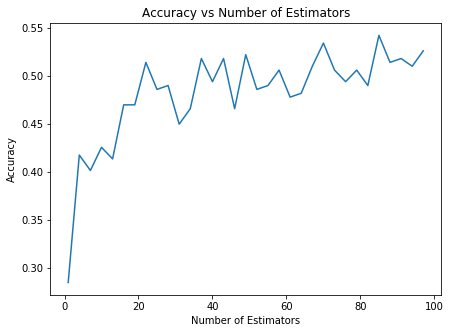

In [683]:
n_est = np.arange(1,100,3)
OS_ = []
for i in n_est:
    rf = RandomForestClassifier(n_estimators=i, n_jobs=-1,min_samples_leaf=20, max_depth=7, max_leaf_nodes=40)
    rf.fit(X_train, y_train)
    pred=rf.predict(X_test)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((rf.predict(X_test) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(n_est,OS_)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Estimators")
#plt.xlim(2,500)
plt.show()

In [684]:
rf = RandomForestClassifier(n_estimators=40, n_jobs=-1,min_samples_leaf=20, max_depth=7, max_leaf_nodes=40)
rf.fit(X_train, y_train)
pred=rf.predict(X_test)

print ('Random Forest Classifier Results: ')
print ('In sample accuracy:',rf.score(X_train,y_train))

# out of sample accuracy
print ('Out of sample accuracy:',rf.score(X_test,y_test))


Random Forest Classifier Results: 
In sample accuracy: 0.765920826162
Out of sample accuracy: 0.502008032129


In [685]:
fet_imp = pd.DataFrame(list(zip(list(X.columns), rf.feature_importances_)), columns=['Variable', 'Importance'])

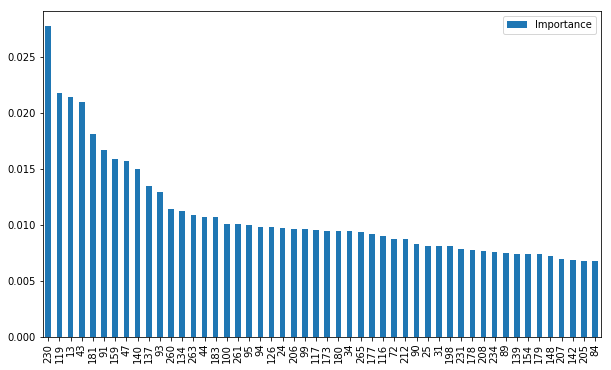

In [686]:
fet_imp.sort_values(by=['Importance'], ascending=False).head(50).plot(kind='bar', figsize=(10,6))

In [689]:
fet_imp.sort_values(by=['Importance'], ascending=False).iloc[:16, :]

,Variable,Importance
230,ENRNUMSPD std05_16,0.027720
119,ENRNUMASI mean05_16,0.021703
13,CLSAVGSPD trend05_16,0.021416
43,ENRNUMHIS trend05_16,0.020920
181,ATTPCTG01 std05_16,0.018075
91,ATTPCTG03 mean05_16,0.016621
159,PPEXPTOTLSV700 mean05_16,0.015814
47,ENRNUMPOV trend05_16,0.015698
140,ENRNUMPRK mean05_16,0.014981
137,ENRNUMMAL mean05_16,0.013488


In [690]:
clust_feats = list(fet_imp.sort_values(by=['Importance'], ascending=False).iloc[:16, :]['Variable'])

In [691]:
X_train_nu = X_train[clust_feats]
X_test_nu = X_test[clust_feats]

In [692]:
# learn model
dt=DecisionTreeClassifier()
dt.fit(X_train_nu,y_train)

print ('Decision Tree Classifier Results: ')
# in sample accuracy
print ('In sample accuracy:',dt.score(X_train_nu,y_train))

# out of sample accuracy
print ('Out of sample accuracy:',dt.score(X_test_nu,y_test))

Decision Tree Classifier Results: 
In sample accuracy: 1.0
Out of sample accuracy: 0.670682730924


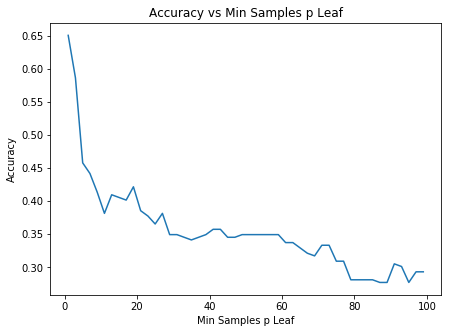

In [693]:
#min_samples_leaf = 
    
min_sam = np.arange(1,100,2)
OS_ = []
for i in min_sam:
    dt = DecisionTreeClassifier(min_samples_leaf=i, random_state=999)
    dt.fit(X_train_nu, y_train)
    pred=dt.predict(X_test_nu)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((dt.predict(X_test_nu) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(min_sam,OS_)
plt.xlabel("Min Samples p Leaf")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Min Samples p Leaf")
#plt.xlim(2,500)
plt.show()

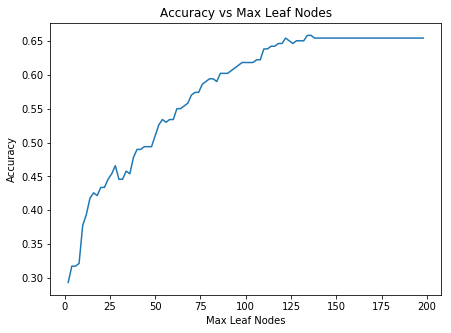

In [695]:
#min_samples_leaf = 
    
max_no = np.arange(2,200,2)
OS_ = []
for i in max_no:
    dt = DecisionTreeClassifier(max_leaf_nodes=i, random_state=999)
    dt.fit(X_train_nu, y_train)
    pred=dt.predict(X_test_nu)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((dt.predict(X_test_nu) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(max_no,OS_)
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Leaf Nodes")
#plt.xlim(2,500)
plt.show()

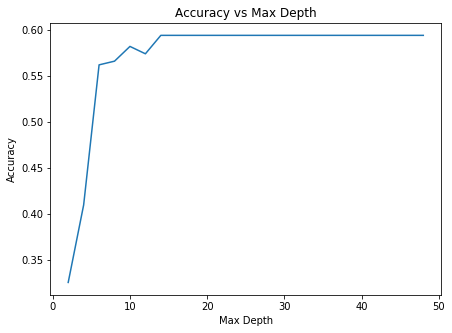

In [696]:
#min_samples_leaf = 
    
max_no = np.arange(2,50,2)
OS_ = []
for i in max_no:
    dt = DecisionTreeClassifier(max_leaf_nodes=80,max_depth=i ,random_state=999)
    dt.fit(X_train_nu, y_train)
    pred=dt.predict(X_test_nu)
    #OS_AUC.append(roc_auc_score(y_test,pred)) #my solution
    OS_.append((dt.predict(X_test_nu) == y_test).sum() / len(y_test))
    
plt.figure(figsize=(7,5))
plt.plot(max_no,OS_)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth")
#plt.xlim(2,500)
plt.show()

In [737]:
# learn model
dt=DecisionTreeClassifier(max_leaf_nodes=75,max_depth=5, min_samples_leaf=20, random_state=999)
dt.fit(X_train_nu,y_train)

print ('Decision Tree Classifier Results: ')
# in sample accuracy
print ('In sample accuracy:',dt.score(X_train_nu,y_train))

# out of sample accuracy
print ('Out of sample accuracy:',dt.score(X_test_nu,y_test))

Decision Tree Classifier Results: 
In sample accuracy: 0.567986230637
Out of sample accuracy: 0.393574297189


In [738]:
type(y_test.iloc[0])

numpy.float64

In [739]:
from sklearn.metrics import confusion_matrix

In [740]:
y_test.value_counts() / y_test.value_counts().sum() 

0.0    0.220884
2.0    0.208835
4.0    0.204819
1.0    0.188755
3.0    0.176707
Name: EnrWhtClust, dtype: float64

In [741]:
(y_pred[y_pred == 1.0] == y_test[y_pred == 1.0]).sum()

11

In [742]:
count_cls_0, count_cls_2, count_cls_4, count_cls_1 , count_cls_3=y_test.value_counts()
y_pred = dt.predict(X_test_nu)

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0.0, 2.0, 4.0, 1.0, 3.0])
print('Confusion matrix:\n', conf_mat)

conf_mat_pct = (np.array(conf_mat.T / np.array([count_cls_0, count_cls_2, count_cls_4, count_cls_1 , count_cls_3])).T)*100.00

Confusion matrix:
 [[21 11 10  3 10]
 [ 7 24  5  9  7]
 [ 3 16 19  5  8]
 [ 2 20  2 11 12]
 [ 8  8  4  1 23]]


Confusion matrix, (%):
 [[ 38.182  20.     18.182   5.455  18.182]
 [ 13.462  46.154   9.615  17.308  13.462]
 [  5.882  31.373  37.255   9.804  15.686]
 [  4.255  42.553   4.255  23.404  25.532]
 [ 18.182  18.182   9.091   2.273  52.273]]


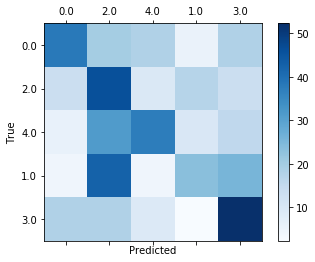

In [755]:
np.set_printoptions(precision=3)
print('Confusion matrix, (%):\n {}'.format(conf_mat_pct))

labels = [0.0, 2.0, 4.0, 1.0, 3.0]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_pct, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [744]:
y_test.value_counts()

0.0    55
2.0    52
4.0    51
1.0    47
3.0    44
Name: EnrWhtClust, dtype: int64

In [745]:
clsses = [str(cl) for cl in dt.classes_]

In [746]:
thestring=tree.export_graphviz(dt, out_file=None, feature_names=X_train_nu.columns.values,
                              class_names=clsses, filled=True)
print (thestring)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="PPEXPTOTLSV700 mean05_16 <= 249.482\ngini = 0.8\nsamples = 581\nvalue = [111, 119, 114, 122, 115]\nclass = 3.0", fillcolor="#3c39e502"] ;
1 [label="ENRNUMHIS trend05_16 <= 3.727\ngini = 0.735\nsamples = 205\nvalue = [79, 14, 19, 50, 43]\nclass = 0.0", fillcolor="#e5813930"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
7 [label="ATTPCTG05 mean05_16 <= 96.296\ngini = 0.754\nsamples = 119\nvalue = [28, 11, 10, 39, 31]\nclass = 3.0", fillcolor="#3c39e517"] ;
1 -> 7 ;
9 [label="ENRNUMASI mean05_16 <= 30.542\ngini = 0.72\nsamples = 89\nvalue = [9, 10, 8, 36, 26]\nclass = 3.0", fillcolor="#3c39e528"] ;
7 -> 9 ;
11 [label="gini = 0.609\nsamples = 26\nvalue = [1, 3, 5, 2, 15]\nclass = 4.0", fillcolor="#e539c079"] ;
9 -> 11 ;
12 [label="ENRNUMGEN mean05_16 <= 787.375\ngini = 0.648\nsamples = 63\nvalue = [8, 7, 3, 34, 11]\nclass = 3.0", fillcolor="#3c39e571"] ;
9 -> 12 ;
13 [label="ENRNUMPRK mean05_16 <=